# Pretrained model on Invasive species classification

## train only with added layers

- The model relies on VGG-16 pretrained model, with `include_top=False`. On top of that, a nn with (1) Dense layer 256 neurons, (2) Output layer 1 neuron, with sigmoid classification.
- This model is revised the previous brutal model, here only the further added top model is trainable.
- Data augmentation is applied upon traing every batch.

## fine tune all bottom layers together with added layers

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob
import os
import sys
interpolation = cv2.INTER_LANCZOS4

## Preprocess training images

In [2]:
master = pd.read_csv("../input/train_labels.csv")
img_path = "../input/train/"

y = []
file_paths = []
for i in range(len(master)):
    file_paths.append( img_path + str(master.iloc[i, 0]) +'.jpg' ) # .ix same as .iloc
    y.append(master.iloc[i,1])
y = np.array(y)

#### This group of functions perfrom preprocessing of input training images

- `centering_image`: input `img` has max size 256, and the other dim < 256. This function does zero_padding to make the `img` to size 256 x 256 x 3
- The input raw image is first resized by the same percentage in col and row, the output image is feed to `cetering_image`
- After that, the img is cropped to size 224 x 224 x 3

In [3]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized


X = []
for i, file_path in enumerate(file_paths):
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = cv2.resize(img, dsize=tile_size, interpolation=interpolation)
    #centering
    img = centering_image(img)
    #out put 224*224px 
    img = img[16:240, 16:240]
    img = img.astype('float32')
    img /= 255.0
    X.append(img)

X = np.array(X)

 ../input/train/2295.jpg from total 2295 images

## Train-test splitting

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2017)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_train (1836, 224, 224, 3)
y_train (1836,)
X_val (459, 224, 224, 3)
y_val (459,)


## Using Keras VGG-16 pretrained model

In [11]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Activation

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, 
                                input_shape=(img_rows, img_cols, img_channel))

In [12]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
layer_pred = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=layer_pred)
#model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3, decay=0.003), metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Set the layers of the pretrained vgg16 model to be fixed.

In [14]:
for layer in model.layers[:19]:
    layer.trainable = False

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Model fitting with data augmentation

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 30

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint('VGG16-transferlearning_topmodel.model', monitor='val_acc', save_best_only=True)])

Epoch 1/30
106s - loss: 0.5454 - acc: 0.7160 - val_loss: 0.3537 - val_acc: 0.8388
Epoch 2/30
105s - loss: 0.2892 - acc: 0.8772 - val_loss: 0.1969 - val_acc: 0.9368
Epoch 3/30
105s - loss: 0.2475 - acc: 0.8999 - val_loss: 0.1634 - val_acc: 0.9455
Epoch 4/30
105s - loss: 0.2144 - acc: 0.9111 - val_loss: 0.1456 - val_acc: 0.9521
Epoch 5/30
103s - loss: 0.1985 - acc: 0.9256 - val_loss: 0.1724 - val_acc: 0.9368
Epoch 6/30
105s - loss: 0.1550 - acc: 0.9446 - val_loss: 0.1052 - val_acc: 0.9717
Epoch 7/30
103s - loss: 0.1346 - acc: 0.9550 - val_loss: 0.1101 - val_acc: 0.9608
Epoch 8/30
103s - loss: 0.1311 - acc: 0.9556 - val_loss: 0.1153 - val_acc: 0.9608
Epoch 9/30
105s - loss: 0.1289 - acc: 0.9556 - val_loss: 0.0849 - val_acc: 0.9739
Epoch 10/30
103s - loss: 0.1160 - acc: 0.9516 - val_loss: 0.0824 - val_acc: 0.9739
Epoch 11/30
103s - loss: 0.0983 - acc: 0.9651 - val_loss: 0.0851 - val_acc: 0.9739
Epoch 12/30
103s - loss: 0.1193 - acc: 0.9605 - val_loss: 0.0775 - val_acc: 0.9717
Epoch 13/30
1

### Model prediction on validation images

In [17]:
model.load_weights('VGG16-transferlearning_topmodel.model')
#model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3, decay=0.003), metrics=['accuracy'])

In [18]:
y_val_pred = model.predict(X_val)

#### Prediction accuracy

In [19]:
y_val_pred_cls = (y_val_pred > 0.5).astype('int')
acc = np.sum(y_val == y_val_pred_cls.reshape(-1)) / y_val.shape[0]
print('Val accuracy: {:.6f}'.format(acc))

Val accuracy: 0.982571


#### ROC curve

In [20]:
from sklearn.metrics import roc_curve, auc
def roc_plot(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

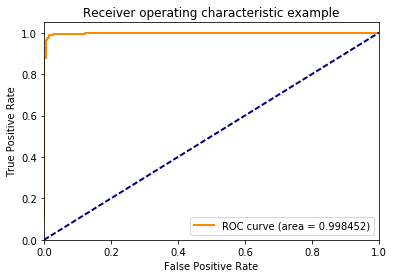

In [21]:
roc_plot(y_val, y_val_pred.reshape(-1))

## Fine-tune the pretrained VGG-16 model plus added layers

In [22]:
for layer in model.layers[:15]:
    layer.trainable = False
for layer in model.layers[15:]: 
    layer.trainable = True
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Start fine tuning with training images

In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

history1 = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint('VGG16-transferlearning_finetune.model', monitor='val_acc', save_best_only=True)])

Epoch 1/20
42s - loss: 0.0508 - acc: 0.9836 - val_loss: 0.0803 - val_acc: 0.9739
Epoch 2/20
41s - loss: 0.0491 - acc: 0.9841 - val_loss: 0.1040 - val_acc: 0.9673
Epoch 3/20
42s - loss: 0.0439 - acc: 0.9857 - val_loss: 0.0704 - val_acc: 0.9782
Epoch 4/20
41s - loss: 0.0408 - acc: 0.9857 - val_loss: 0.1001 - val_acc: 0.9673
Epoch 5/20
41s - loss: 0.0520 - acc: 0.9819 - val_loss: 0.0793 - val_acc: 0.9760
Epoch 6/20
41s - loss: 0.0431 - acc: 0.9852 - val_loss: 0.0740 - val_acc: 0.9782
Epoch 7/20
41s - loss: 0.0371 - acc: 0.9852 - val_loss: 0.1011 - val_acc: 0.9630
Epoch 8/20
41s - loss: 0.0351 - acc: 0.9868 - val_loss: 0.1053 - val_acc: 0.9608
Epoch 9/20
41s - loss: 0.0356 - acc: 0.9890 - val_loss: 0.0851 - val_acc: 0.9717
Epoch 10/20
41s - loss: 0.0424 - acc: 0.9835 - val_loss: 0.0814 - val_acc: 0.9760
Epoch 11/20
41s - loss: 0.0372 - acc: 0.9874 - val_loss: 0.0734 - val_acc: 0.9760
Epoch 12/20
41s - loss: 0.0386 - acc: 0.9857 - val_loss: 0.1323 - val_acc: 0.9521
Epoch 13/20
41s - loss: 0

### Model prediction on validation images

In [24]:
model.load_weights('VGG16-transferlearning_finetune.model')
#model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
y_val_pred = model.predict(X_val)

#### Prediction accuracy

In [25]:
y_val_pred_cls = (y_val_pred > 0.5).astype('int')
acc = np.sum(y_val == y_val_pred_cls.reshape(-1)) / y_val.shape[0]
print('Val accuracy: {:.6f}'.format(acc))

Val accuracy: 0.978214


#### ROC curve

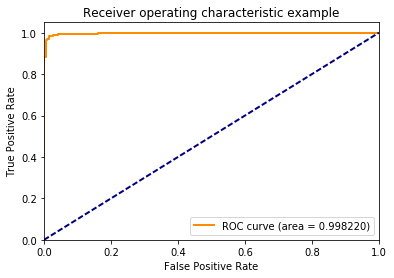

In [26]:
roc_plot(y_val, y_val_pred.reshape(-1))

## Fine tuning the whole network start from the *topmodel*

In [27]:
model.load_weights('VGG16-transferlearning_topmodel.model')
for layer in model.layers: 
    layer.trainable = True
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)

history1 = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint('VGG16-transferlearning_finetuneall.model', monitor='val_acc', save_best_only=True)])

Epoch 1/20
105s - loss: 0.0516 - acc: 0.9808 - val_loss: 0.0956 - val_acc: 0.9739
Epoch 2/20
104s - loss: 0.0645 - acc: 0.9777 - val_loss: 0.0753 - val_acc: 0.9804
Epoch 3/20
103s - loss: 0.0486 - acc: 0.9841 - val_loss: 0.1090 - val_acc: 0.9673
Epoch 4/20
103s - loss: 0.0627 - acc: 0.9805 - val_loss: 0.0976 - val_acc: 0.9651
Epoch 5/20
103s - loss: 0.0405 - acc: 0.9879 - val_loss: 0.1189 - val_acc: 0.9586
Epoch 6/20
104s - loss: 0.0379 - acc: 0.9852 - val_loss: 0.0573 - val_acc: 0.9826
Epoch 7/20
103s - loss: 0.0880 - acc: 0.9682 - val_loss: 0.0969 - val_acc: 0.9608
Epoch 8/20
103s - loss: 0.0669 - acc: 0.9781 - val_loss: 0.1189 - val_acc: 0.9630
Epoch 9/20
103s - loss: 0.0439 - acc: 0.9837 - val_loss: 0.0984 - val_acc: 0.9695
Epoch 10/20
103s - loss: 0.0333 - acc: 0.9907 - val_loss: 0.1131 - val_acc: 0.9651
Epoch 11/20
103s - loss: 0.0403 - acc: 0.9863 - val_loss: 0.0606 - val_acc: 0.9804
Epoch 12/20
103s - loss: 0.0284 - acc: 0.9907 - val_loss: 0.0865 - val_acc: 0.9695
Epoch 13/20
1

### Model prediction on validation images

In [30]:
model.load_weights('VGG16-transferlearning_finetuneall.model')
#model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])
y_val_pred = model.predict(X_val)

#### Prediction accuracy

In [31]:
y_val_pred_cls = (y_val_pred > 0.5).astype('int')
acc = np.sum(y_val == y_val_pred_cls.reshape(-1)) / y_val.shape[0]
print('Val accuracy: {:.6f}'.format(acc))

Val accuracy: 0.986928


#### ROC Curve

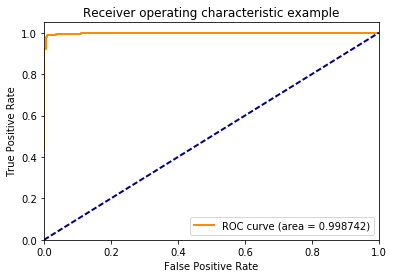

In [32]:
roc_plot(y_val, y_val_pred.reshape(-1))

## Predict on test images

### Load test images

In [33]:
sample_submission = pd.read_csv("../input/sample_submission.csv")
img_path = "../input/test/"

test_names = []
file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.iloc[i,0])
    file_paths.append( img_path + str(int(sample_submission.iloc[i,0])) +'.jpg' )

test_names = np.array(test_names)

In [34]:
X_test = []
for i, file_path in enumerate(file_paths):
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()

    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    #centering
    img = centering_image(cv2.resize(img, dsize=tile_size, interpolation=interpolation))
    
    #out put 224*224px 
    img = img[16:240, 16:240]
    img = img.astype('float32')
    img /= 255.0
    X_test.append(img)

X_test = np.array(X_test)

 ../input/test/1531.jpg from total 1531 images

### Model load and prediction

In [35]:
model.load_weights('VGG16-transferlearning_finetuneall.model')
y_test_pred = model.predict(X_test)

### Write to file

In [36]:
def submission_to_csv(test_preds, file_path):
    sample_submission = pd.read_csv("../input/sample_submission.csv")
    for i, name in enumerate(test_names):
        sample_submission.loc[sample_submission['name'] == name, 'invasive'] = test_preds[i]
    sample_submission.to_csv(file_path, index=False)

In [37]:
submission_to_csv(test_preds=y_test_pred, file_path='submit_finetuneall.csv')